In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from pyvis.network import Network
from tqdm import tqdm
import pickle

In [2]:
with open("./saved_objects/main_graph.pkl", "rb") as f:
    G = pickle.load(f)
with open("./saved_objects/artist_info.pkl", "rb") as f:
    artist_info = pickle.load(f)


# 2. Various Whole Graph Measures
## _Degree Distribution:_

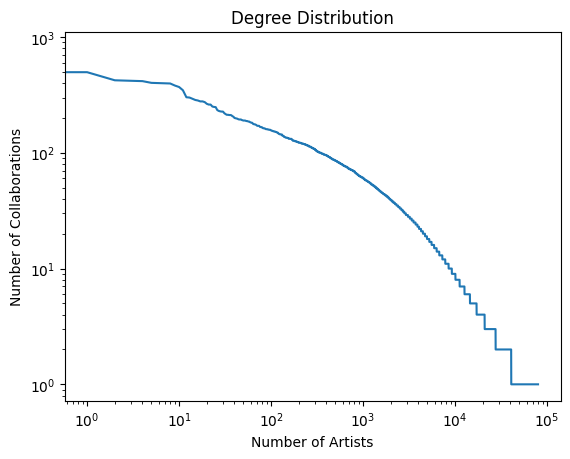

In [3]:
deg_sorted_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
degrees = [deg for (_, deg) in deg_sorted_nodes]

# Plot Degree Distribution
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees)
ax.set_xscale('log'), ax.set_yscale('log')
plt.title("Degree Distribution")
ax.set_xlabel("Number of Artists")
ax.set_ylabel("Number of Collaborations")
plt.show()


In [4]:
# Display Hub Artists
print("Artists with highest number of collaborators: ")
for i in range(10):
    print("\t" + artist_info[deg_sorted_nodes[i][0]][0] + " (" + str(deg_sorted_nodes[i][1]) + ")")

Artists with highest number of collaborators: 
	Johann Sebastian Bach (799)
	Mc Gw (497)
	Armin van Buuren (423)
	Traditional (419)
	Diplo (416)
	R3HAB (402)
	Snoop Dogg (400)
	Tiësto (399)
	Steve Aoki (397)
	David Guetta (381)


In [5]:
# Figure out how many nodes with one degree
leaf_vertices = [node for node in G.nodes if G.degree(node) == 1]

print(len(leaf_vertices))
# Large amount of leaf verticies.


39101


In [6]:
# Interpreting the Skew

def calc_gini_coeff(degrees):
    n = len(degrees)
    sorted_degrees = sorted(degrees)
    cumulative_sums = sum(sorted_degrees)
    weighted_sum = sum((i+1) * degree for i, degree in enumerate(sorted_degrees))
    gini_index = (2 * weighted_sum) / (n * cumulative_sums) - (n + 1) / n
    return gini_index

def calc_power_law_coeff(degrees):
    sum_log_degrees = sum(np.log(degree / 1) for degree in degrees)
    pl_coefficient = 1 + len(degrees) * (sum_log_degrees**-1)
    return pl_coefficient

pl_coeff = calc_power_law_coeff(degrees)
gini_coeff = calc_gini_coeff(degrees)
print("Power-Law Coefficient: ", pl_coeff)
print("Gini Coefficient: ", gini_coeff) #  Equatorial Guinea

Power-Law Coefficient:  2.223107906005194
Gini Coefficient:  0.6889668727786651


## _Connectivity Analysis_

In [7]:
nx.is_connected(G)
nx.number_connected_components(G)
print(f"Graph is not connected and has {nx.number_connected_components(G)} components") 

Graph is not connected and has 1 components


Failed at k=3 with error: maximum recursion depth exceeded


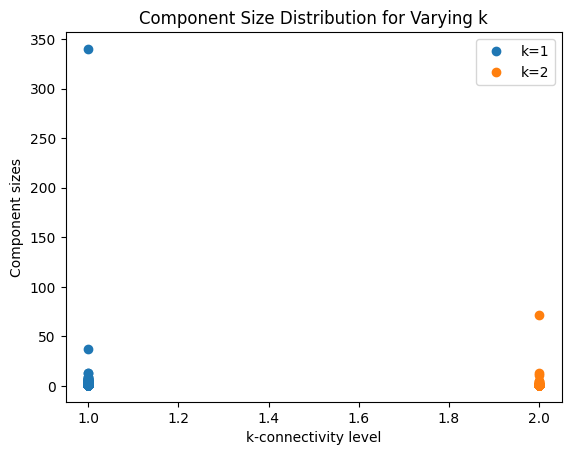

In [8]:
# Mining k-connectivity
def k_edge_decompositions_estimated(graph, max_k, sample_size):
    sizes = {}
    # Sample a subset of nodes
    sampled_nodes = np.random.choice(graph.nodes(), sample_size)
    # Create a subgraph with the sampled nodes
    subgraph = graph.subgraph(sampled_nodes)
    
    for k in range(1, max_k+1):
        try:
            # Compute the k-edge-connected components for the subgraph
            components = list(nx.k_edge_components(subgraph, k))
            sizes[k] = [len(c) for c in components]
        except Exception as e:
            print(f"Failed at k={k} with error: {str(e)}")
            break

    return sizes


def plot_component_sizes(sizes):
    fig, ax = plt.subplots()
    for k, comp_sizes in sizes.items():
        ax.plot([k]*len(comp_sizes), comp_sizes, 'o', label=f'k={k}')
    ax.set_xlabel('k-connectivity level')
    ax.set_ylabel('Component sizes')
    ax.set_title('Component Size Distribution for Varying k')
    ax.legend()
    plt.show()


# Define the maximum k to test
max_k = 3
sample_size = 5000
sizes = k_edge_decompositions_estimated(G, max_k, sample_size)
plot_component_sizes(sizes)

In [9]:
# Find K-cores and cut edges
# Find and print k-cores

def find_k_cores(graph, max_k):
    cores = {}
    for k in range(1, max_k+1):
        core = nx.k_core(graph, k=k)
        cores[k] = nx.number_of_nodes(core)
    return cores
k_cores = find_k_cores(G, 10)
print("k-core sizes:", k_cores)



k-core sizes: {1: 79851, 2: 39815, 3: 25401, 4: 17612, 5: 12874, 6: 9942, 7: 7997, 8: 6455, 9: 5206, 10: 4303}


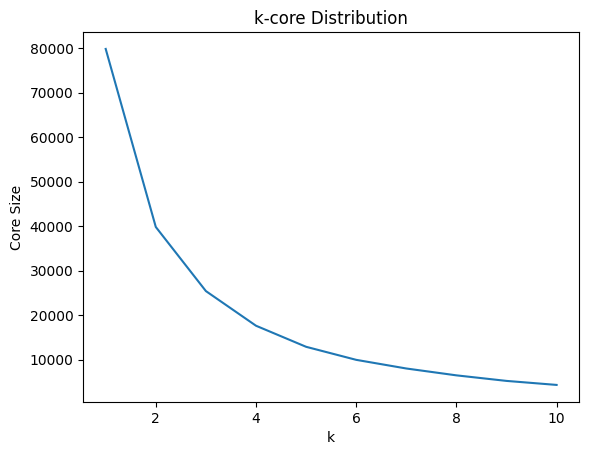

In [10]:
# plot k-core distribution
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_cores.keys(), k_cores.values())
# ax.set_xscale('log'), ax.set_yscale('log')
plt.title("k-core Distribution")
ax.set_xlabel("k")
ax.set_ylabel("Core Size")
plt.show()

# Compare with configuration null model

In [11]:
# Analyze bridges

# Find and print cut-edges

# Perhaps sort by most influential cut edge

# def bridge_influence_by_displacement(graph):
#     bridge_influence = []
#     for u, v in tqdm(list(nx.bridges(graph))):
#         # Remove the edge and calculate the impact
#         graph.remove_edge(u, v)
#         bridge_influence.append(((u, v), min(len(c) for c in nx.connected_components(graph))))
#         # Restore the edge
#         graph.add_edge(u, v)
#     return bridge_influence

# # Evaluate the influence of each bridge
# influence = bridge_influence_by_displacement(G.copy())
# # Sort bridges by their influence (smaller component size when removed)
# influence.sort(key=lambda x: x[1], reverse=True)
# with open("./saved_objects/cut_edges_by_influence.pkl", "wb") as f:
#     pickle.dump(influence, f)


with open("./saved_objects/cut_edges_by_influence.pkl", "rb") as f:
    bridges_by_influence = pickle.load(f)


In [12]:
# Interpret bridges
bridges_by_influence
# for (u,v), _ in bridges_by_influence[:10]:
#     print(artist_info[u][0], artist_info[v][0])

[(('2HvyR5FsU37QMqVzIbGwl7', '6J8GiTR6EKnHeTRwgNh46q'), 19),
 (('2J3qGaj5UzHvu0fjlLgb8k', '6J8GiTR6EKnHeTRwgNh46q'), 18),
 (('5jFvzkcrrV8TqpRo2sMRuK', '2Q81XxBsZUuH4kises0nEa'), 15),
 (('6urkHDoIVO1WO8vNIwcJmM', '6aDX1jzNVAI9enlQzW0Pgw'), 14),
 (('2F8GvYuY0lfZNYu45dY6gJ', '6bvtY9dkfSa5yKuogd2aLU'), 13),
 (('5jFvzkcrrV8TqpRo2sMRuK', '3AEPOScEpyXGfeHa3scvkm'), 13),
 (('0AtQAehoytV7j1r4O16dRb', '0OpWIlokQeE7BNQMhuu2Nx'), 12),
 (('2CfEAlvAtAJ7MvCQl4mptz', '3AEPOScEpyXGfeHa3scvkm'), 12),
 (('4XnnBdCt9Cg5W2wBgtD7co', '6mJII5SJlWEYnf7DY4Uywl'), 12),
 (('3Bej6ikcqBylMRbkX1DKpu', '6hyCmqlpgEhkMKKr65sFgI'), 11),
 (('18mGtkaRoIjbOaGT1rykKP', '6dXL3SnQlCGX9LCUAyin6a'), 11),
 (('56KP7DzAzkI8AlAKbt4N6t', '0yknwn0XnsbFLagS80AA0n'), 11),
 (('2lD1D6eEh7xQdBtnl2Ik7Y', '3RPu1pwXXrPqamAp6OHZ8b'), 11),
 (('6aGmKxXoKrSdovRUn8MBhZ', '6geC8EbDc3ifaSAbx3RESQ'), 11),
 (('4gGGFclZZyED2i5BgzGAlD', '311Xf4oyUUgMiVyMvrjIsO'), 11),
 (('6lQbKezHkug0aJSkAjYYO5', '6geC8EbDc3ifaSAbx3RESQ'), 10),
 (('1fLIzbK5e8MGrLKj1dEM

## _Small-World Analysis_

In [13]:
def estimate_avg_sp(G):
    sample = np.random.choice(G, 100)  # Assumed that the graph is connected

    avg_path_lengths = []
    for node in tqdm(sample):
        paths = nx.single_source_shortest_path(G, source=node)
        path_lengths = [len(path) for path in paths.values()]
        avg_path_lengths.append(sum(path_lengths) / len(path_lengths))

    return sum(avg_path_lengths) / 100

avg_shortest_paths = estimate_avg_sp(G)
print(avg_shortest_paths)
# neither extremely compact nor excessively sparse,
# Graph is Moderately dispursed

100%|██████████| 100/100 [00:53<00:00,  1.89it/s]

6.938339532379055


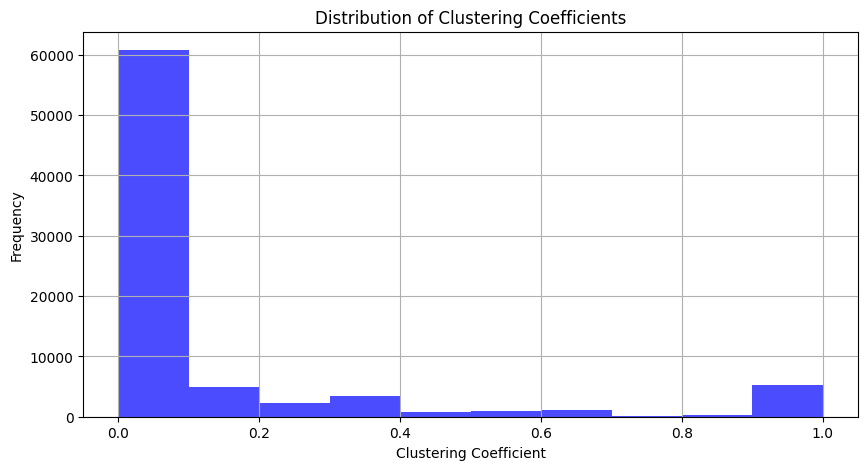

Avg clustering coeff: 0.12283297049959999


In [14]:
# Calculate clustering coefficent
cluster_coeffs = nx.clustering(G)

plt.figure(figsize=(10, 5))
plt.hist(cluster_coeffs.values(), bins=10, color='blue', alpha=0.7)
plt.title('Distribution of Clustering Coefficients')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


avg_cluster = np.mean(list(cluster_coeffs.values()))
print("Avg clustering coeff:", avg_cluster)

In [15]:
cluster_coeffs.values()

dict_values([0, 0.0768361581920904, 0.14285714285714285, 0.044444444444444446, 0, 0.3333333333333333, 0.8333333333333334, 0, 0, 0, 0.006747638326585695, 0.3333333333333333, 0, 0, 0.3, 0.0215148835838491, 0.0035650623885918, 0.024635669673837613, 0.01282051282051282, 0, 0.14814814814814814, 0.04994192799070848, 0.11666666666666667, 0, 0.3055555555555556, 0, 0.04628704628704629, 0, 0.12727272727272726, 0.09047619047619047, 0, 0.02926829268292683, 0, 0.07293868921775898, 0.06666666666666667, 0, 0.01098901098901099, 0, 0, 0.13333333333333333, 0, 0.1, 0.13186813186813187, 0.05454545454545454, 0, 0.10526315789473684, 0.06333333333333334, 0, 0, 0, 0, 0.03694581280788178, 0.2857142857142857, 0, 0, 0, 0.12121212121212122, 0.009852216748768473, 0.015151515151515152, 0, 0, 0.07017543859649122, 0, 0, 0.10569105691056911, 0.09523809523809523, 0.05621500559910415, 0.1921182266009852, 0, 0, 0.1, 0.09659090909090909, 0, 0.3333333333333333, 0, 0, 0.08333333333333333, 0, 0.024886877828054297, 0.13333333

In [18]:
# Estimate the diameter of the graph
def estimate_graph_diameter(G, num_iterations=5):
    # Choose an initial random vertex as the root
    v = random.choice(list(G.nodes()))
    estimated_diameter = 0

    for _ in range(num_iterations):
        # Perform BFS from the current vertex v
        lengths = nx.single_source_shortest_path_length(G, v)
        # Find the vertex furthest from v
        furthest_node, furthest_distance = max(lengths.items(), key=lambda x: x[1])
        
        # Update the estimated diameter if the current distance is larger
        if furthest_distance > estimated_diameter:
            estimated_diameter = furthest_distance
            v = furthest_node
        else:
            # If the diameter estimate does not increase, break early
            break

    return estimated_diameter

print("Graph diameter: ~" + str(estimate_graph_diameter(G)))

TypeError: can only concatenate str (not "int") to str